# Introduction
This is a series that I am very excited about. We are going to explore some unsupervised models, the main idea is to understand the X-space or the space of the feautures.

All the other things we saw so far explore how feautures helps us make certain kind of predictions. And then we look deeper at the model itself and try to explain how those feauture impact the model (shap and permutation analysis).

But we haven't stopped to analysis with greater care how all the feautures that make those predictions move together. That what we are going to explore here. Graph theory was the only exception, because with graph theory we understand the underlying pattern of connections.

We already saw PCA. Now we are going to use other method to reduce dimensionality (and hopefully not reducing as much our target indicator) The method is called singular value decomposition.
Here we can use all the columns :) PCA didn't allow for sparce vector.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
# new library, we haven't used this one before in this repo
from sklearn.decomposition import TruncatedSVD

In [2]:
# Read the data
# This data you can find here: https://www.kaggle.com/c/home-data-for-ml-course/data

X_full = pd.read_csv('train.csv', index_col='Id')

# SalePrice is the target, if there is no target eliminate row associated with it
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X = X_full.copy()
X.drop(['SalePrice'], axis=1, inplace=True)

In [3]:
def transforming_svd(X):
    
    # for PCA it is best to scale all numerical values.
    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    

    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=3))
      ]
        )
    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')


    # Create principal components
    svd = TruncatedSVD(n_components=len(X.columns), n_iter=7, random_state=42)
    
    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', svd)
                         ])

    
    X_svd = pipe.fit_transform(X)
    
    return  X_svd,pipe['model']

In [4]:
X_svd,svd = transforming_svd(X)

In [5]:
# Convert to dataframe
component_names = [f"svd{i+1}" for i in range(X_svd.shape[1])]
X_svd = pd.DataFrame(X_svd, columns=component_names)

X_svd.head()

,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,...,svd70,svd71,svd72,svd73,svd74,svd75,svd76,svd77,svd78,svd79
0,5.860690,2.284791,0.400613,-2.047690,-1.921106,0.257161,0.141224,1.044548,-1.500667,-0.192149,...,0.050206,-0.227046,-0.166864,-0.041210,-0.104147,0.176049,-0.033400,0.164387,-0.198624,-0.002622
1,5.414994,-0.138018,-1.216137,1.523959,-0.350276,-1.610951,-0.685855,0.050043,2.115816,2.596983,...,0.133095,0.133786,0.279779,-0.251253,0.131960,-0.165306,-0.392031,-0.248289,-0.226464,0.051063
2,5.594409,2.655626,0.246532,-1.695302,-1.624716,-0.463115,-0.248818,0.178135,-0.336623,-0.667962,...,0.347896,-0.109072,-0.104064,-0.097918,0.086932,0.219050,0.005301,0.133161,-0.277176,-0.109505
3,5.172234,-0.770623,1.476583,0.680120,-0.141320,0.111859,2.144862,-0.862289,-1.791348,-0.988139,...,-0.941915,0.454812,0.130993,-0.771417,0.374406,0.473870,-0.097151,0.530386,-0.295799,-0.090091
4,5.455996,5.031450,1.397822,-0.292417,-1.556573,-0.248187,-0.579570,0.029379,-0.084205,-0.276990,...,-0.004192,0.087968,-0.128439,0.013173,-0.056702,-0.189072,-0.141733,-0.019693,0.092247,-0.103336


In [6]:
X_svd.shape

(1460, 79)

In [7]:
X.shape

(1460, 79)

In [8]:
def plot_variance(svd, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = len(X_svd.columns)
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = svd.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance"
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance"
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

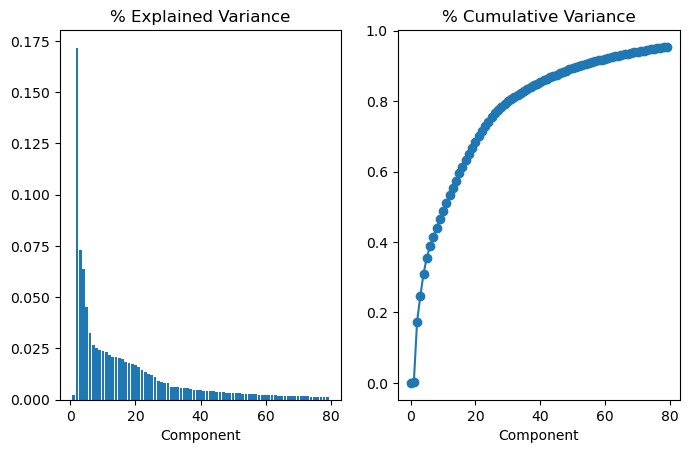

In [9]:
plot_variance(svd)

# Comparing models

we are going to compare two models one using the SVD and the other using the normal input space and compare them.

Using all variables of SCD (In this case both model should be equal or very similar)
Using variables that explain 80% of input space variance.

This pipeline we will use:

In [10]:
def transforming_modeling_scoring(X,y,n_estimators=369,cv=5, scoring='neg_mean_absolute_error'):

    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]

    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]

    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=3))
      ]
        )


    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestRegressor(n_estimators=n_estimators,random_state=0,n_jobs=-1)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    
    scores = -1 * cross_val_score(pipe, X, y,cv=cv,scoring=scoring)

    return scores

In [11]:
score = transforming_modeling_scoring(X_svd,y)
score = score.mean()
score

17817.809139844823

In [12]:
score_without_svc = transforming_modeling_scoring(X,y)
score_without_svc = score_without_svc.mean()
score_without_svc

17572.00848461224

## we use only until we explain 80% variance input space

In [13]:
def number_components(svd,wanted_variance = 0.8):
    variance_explain = 0
    evr = svd.explained_variance_ratio_
    number_components = 0
    for variance in list(evr):
        #print(variance_explain)
        variance_explain = variance_explain + variance
        number_components = number_components + 1
        if variance_explain > wanted_variance - 0.001:
            break
    return variance_explain,number_components

In [14]:
variance_explain,number_components = number_components(svd)
print(f"with {number_components} components we explain {round(100*variance_explain,2)}% of the variance")

with 31 components we explain 80.52% of the variance


In [15]:
X_svd = X_svd[X_svd.columns[0:number_components]]

In [16]:
score = transforming_modeling_scoring(X_svd,y)
score_with_svd = score.mean()
score_with_svd

17472.60851431117

In [17]:
porcetual_diff = 100*(score_with_svd - score_without_svc)/score_without_svc
porcetual_diff

-0.5656722189049402

In [18]:
text = str(f"""
Notice that we unexpectently reduce by {round(porcetual_diff,2)}% 
the MAE evem though we reduce the number of columns. So SVD has
{number_components} vs {len(X.columns)} that we have at the beginning.
reducing by {round(100*(len(X.columns)-number_components)/len(X.columns),2)}% 

""")
print(text)


Notice that we unexpectently reduce by -0.57% 
the MAE evem though we reduce the number of columns. So SVD has
31 vs 79 that we have at the beginning.
reducing by 60.76% 




This was highly unexpected. But this can be because we eliminate a little the noise of the data and because we use less feautures maybe the model is not overfitting so much. But it can also be a fluke! 